In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime
from utils.mvo_strategy import MVOPortfolio

%load_ext autoreload
%autoreload 2

In [6]:
sector_tickers = [
    "XLF",  # Financials
    "XLK",  # Technology
    "XLV",  # Health Care
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLI",  # Industrials
    "XLU",  # Utilities
    "XLB",  # Materials
    "XLRE",  # Real Estate
    "XLC",  # Communication Services
]

# import data from csv
df_ret = pd.read_parquet("../data/returns.parquet")
df_prices = pd.read_parquet("../data/prices.parquet")
df_vol = pd.read_parquet("../data/vola.parquet")

df_spy = pd.read_parquet("../data/prices_sp500.parquet")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"../results/{timestamp}_mvo_backtest/"
os.makedirs(results_dir, exist_ok=True)

In [8]:
# Test different lookback periods
lookback_periods = [10, 30, 60, 90, 120, 150, 252, 252 * 2, 252 * 3, 252 * 3.5]
# make sure all are integers
lookback_periods = [int(period) for period in lookback_periods]

START_DATE = "2010-01-02"
END_DATE = "2021-12-31"

In [ ]:
all_history = []
all_metrics = []

for lookback in lookback_periods:
    print(f"Running MVO with lookback period: {lookback}")
    optimizer = MVOPortfolio(tickers=sector_tickers, lookback=lookback)
    portfolio = optimizer.backtest(
        df_ret, df_prices, start_date=START_DATE, end_date=END_DATE
    )

    portfolio_df = pd.DataFrame(portfolio.get_history())
    portfolio_df["lookback"] = lookback

    portfolio_metrics = portfolio.calc_metrics()
    portfolio_metrics["lookback"] = lookback

    all_history.append(portfolio_df)
    all_metrics.append(portfolio_metrics)

Running MVO with lookback period: 10


Running backtest: 100%|██████████| 3130/3130 [00:25<00:00, 123.63it/s]


Running MVO with lookback period: 30


Running backtest: 100%|██████████| 3130/3130 [00:28<00:00, 108.38it/s]


Running MVO with lookback period: 60


Running backtest: 100%|██████████| 3130/3130 [00:31<00:00, 100.87it/s]


Running MVO with lookback period: 90


Running backtest: 100%|██████████| 3130/3130 [00:34<00:00, 91.28it/s] 


Running MVO with lookback period: 120


Running backtest: 100%|██████████| 3130/3130 [00:37<00:00, 82.79it/s] 


Running MVO with lookback period: 150


Running backtest: 100%|██████████| 3130/3130 [00:38<00:00, 82.16it/s] 


Running MVO with lookback period: 252


Running backtest: 100%|██████████| 3130/3130 [00:41<00:00, 76.31it/s] 


Running MVO with lookback period: 504


Running backtest: 100%|██████████| 3130/3130 [00:46<00:00, 67.17it/s]


Running MVO with lookback period: 756


Running backtest: 100%|██████████| 3130/3130 [00:47<00:00, 66.12it/s]


Running MVO with lookback period: 882


Running backtest: 100%|██████████| 3130/3130 [00:47<00:00, 65.72it/s]


In [6]:
# Combine all results
history_df = pd.concat(all_history, axis=0)
metrics_df = pd.DataFrame(all_metrics)

history_df.to_parquet(f"{results_dir}/mvo_history.parquet")
metrics_df.to_csv(f"{results_dir}/mvo_metrics.csv")

In [19]:
# Load df from previous run
results_dir = "../results/20250602_010152_mvo_backtest"
history_df = pd.read_parquet(f"{results_dir}/mvo_history.parquet")
metrics_df = pd.read_csv(f"{results_dir}/mvo_metrics.csv")

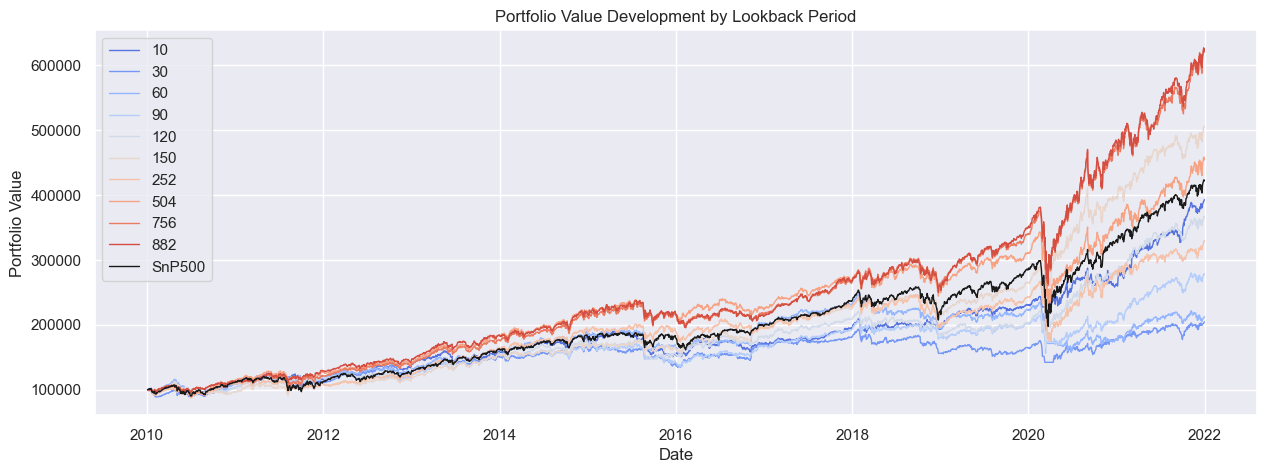

In [20]:
# compare with portfolio value development if i just buy and hold SPY
initial_balance = 100_000
shares_spy = initial_balance / df_spy["^GSPC"].loc[df_spy.index > START_DATE].iat[0]

# PLOT Portfolio Value Development
plt.figure(figsize=(15, 5))
palette = sns.color_palette(
    "coolwarm", as_cmap=False, n_colors=history_df["lookback"].nunique()
)
sns.lineplot(
    data=history_df, x="date", y="portfolio_value", hue="lookback", palette=palette, lw=1
)

plt.plot(df_spy["^GSPC"].loc[START_DATE:END_DATE] * shares_spy, c="k", label="SnP500", lw=1)

plt.title("Portfolio Value Development by Lookback Period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
# save plot
plt.savefig(f"{results_dir}/portfolio_value_development.pdf", dpi=300)

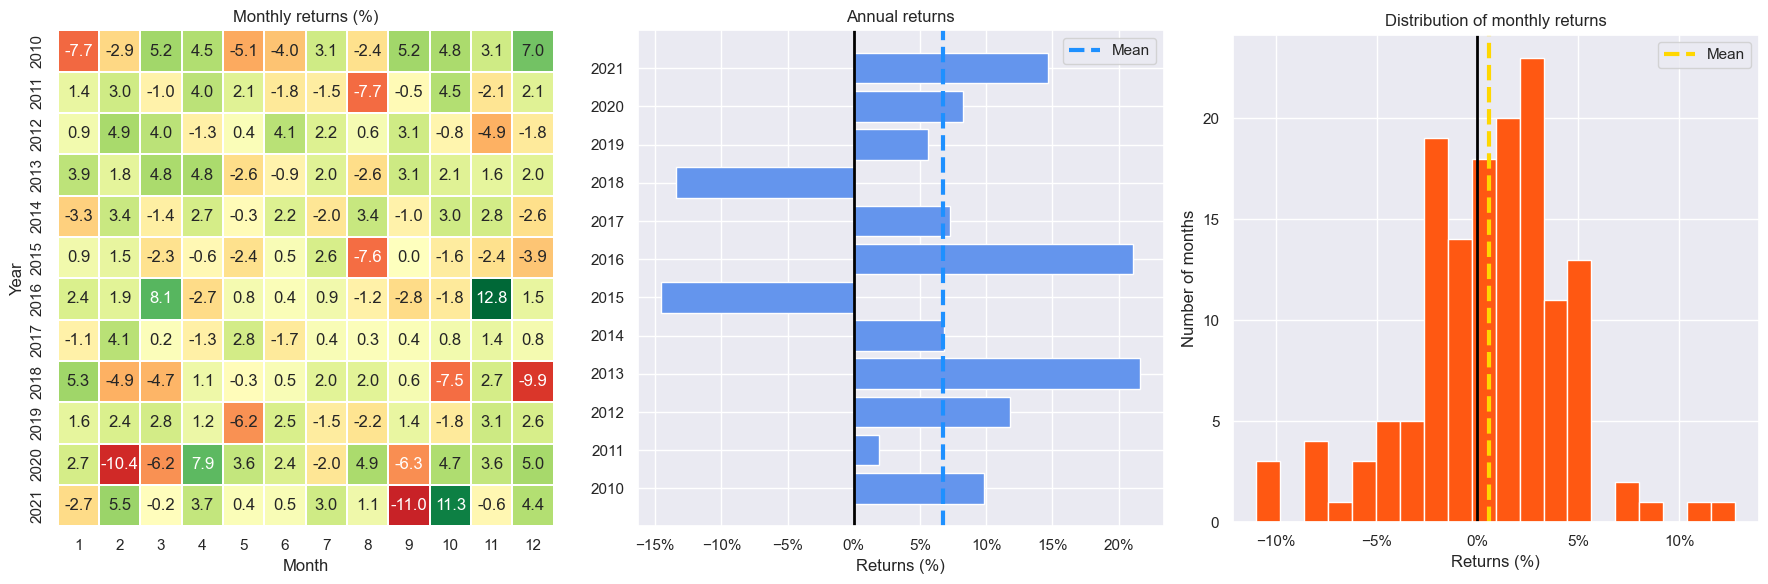

In [21]:
# Filter relevant lookback
focus_df = history_df[history_df['lookback'] == 30]

# === Monthly returns ===
month_df = focus_df[['portfolio_value']].resample('ME').last()
month_df = pd.concat([pd.DataFrame({'portfolio_value': [initial_balance]}, index=[month_df.index.min() - pd.DateOffset(months=1)]), month_df])
month_df['monthly_ret'] = month_df['portfolio_value'].pct_change() * 100
month_df = month_df.iloc[1:]
month_df['year'] = month_df.index.year
month_df['month'] = month_df.index.month
monthly_pivot = month_df.pivot(index='year', columns='month', values='monthly_ret')
monthly_rets = month_df['monthly_ret'].values

# === Annual returns ===
annual_df = focus_df[['portfolio_value']].resample('YE').last()
annual_df = pd.concat([pd.DataFrame({'portfolio_value': [initial_balance]}, index=[annual_df.index.min() - pd.DateOffset(years=1)]), annual_df])
annual_df['annual_ret'] = annual_df['portfolio_value'].pct_change() * 100
annual_df = annual_df.iloc[1:]
annual_df['year'] = annual_df.index.year
annual_mean = annual_df['annual_ret'].mean()

# === PLOT with square plots and updated formatting ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme()

# 1. Monthly heatmap
sns.heatmap(
    monthly_pivot,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar=False,
    linewidths=0.2,
    linecolor='white'
)
axes[0].set_title("Monthly returns (%)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_aspect('equal')

# 2. Annual returns bar chart (scaled to %)
axes[1].barh(annual_df['year'], annual_df['annual_ret'], color="cornflowerblue")
axes[1].axvline(x=annual_mean, color="dodgerblue", linestyle="--", lw=3, label="Mean")
axes[1].set_title("Annual returns")
axes[1].set_yticks(annual_df['year'])

# 3. Monthly return distribution
axes[2].hist(monthly_rets, bins=20, color="#ff5812", edgecolor="white")
axes[2].axvline(x=monthly_rets.mean(), color="gold", linestyle="--", lw=3, label="Mean")
axes[2].set_title("Distribution of monthly returns")
axes[2].set_ylabel("Number of months")
axes[2].set_aspect('equal')

for idx in [1,2]:
    axes[idx].axvline(x=0, color="black", lw=2)
    axes[idx].set_xlabel("Returns (%)")
    axes[idx].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axes[idx].legend()

plt.tight_layout()
plt.savefig(f"{results_dir}/paper_figure4_returns.pdf", dpi=300)

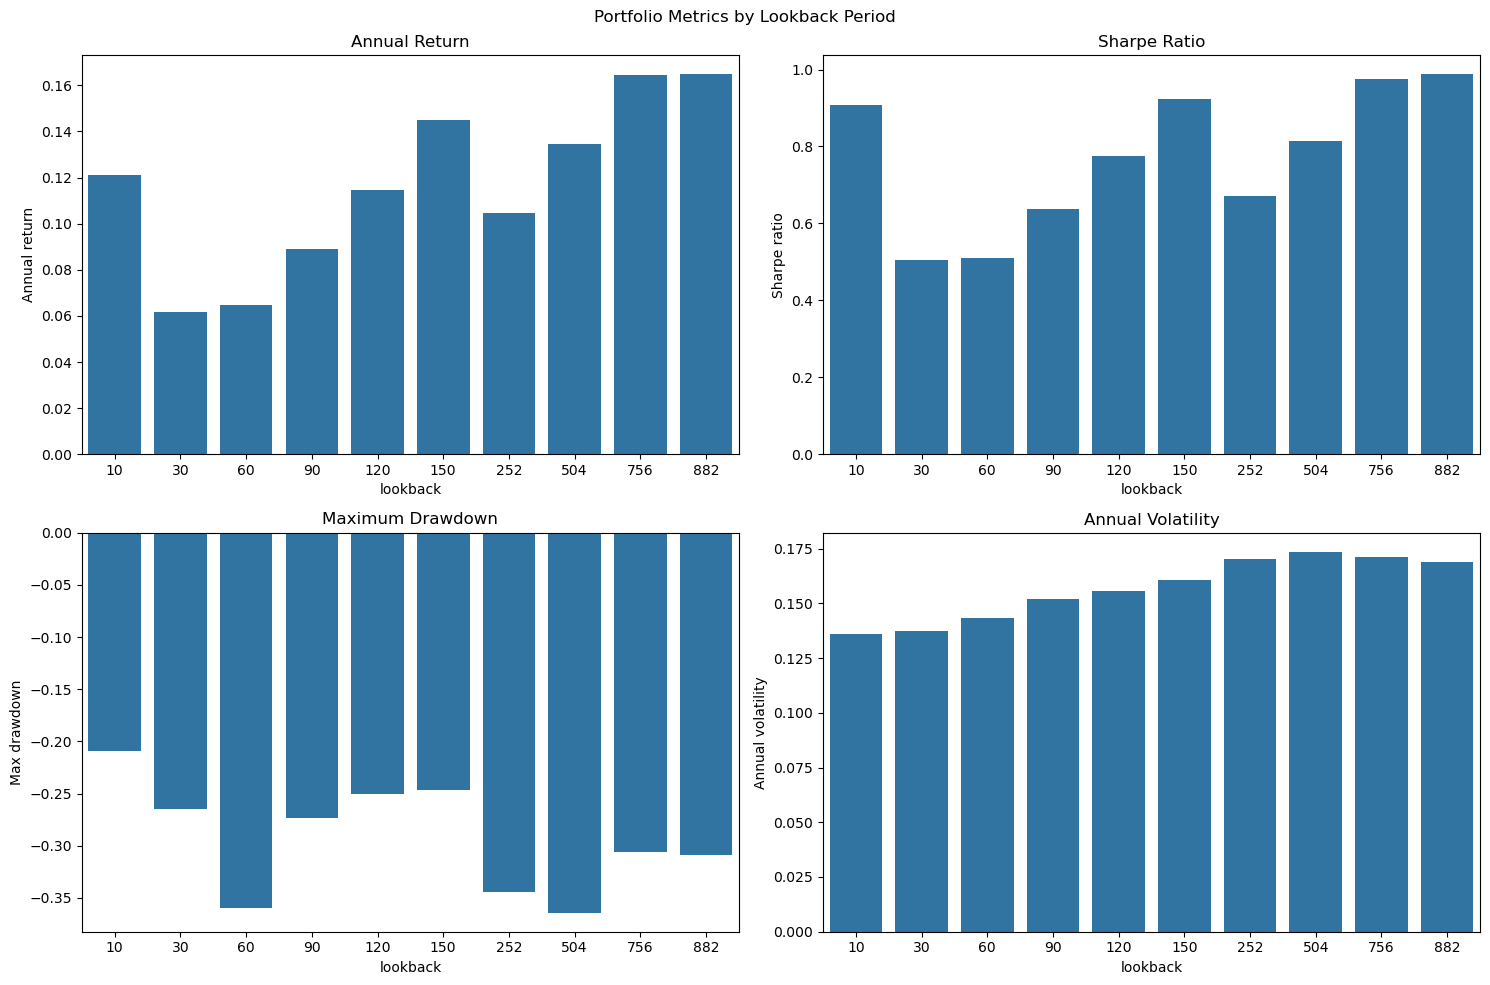


Detailed Metrics by Lookback Period:


lookback,10,30,60,90,120,150,252,504,756,882
Annual return,0.120999,0.061574,0.064798,0.089041,0.114475,0.144898,0.104725,0.134617,0.164526,0.164780
Cumulative returns,2.928959,1.045914,1.121599,1.778417,2.663607,4.058669,2.297559,3.540517,5.201239,5.217463
Annual volatility,0.135859,0.137467,0.143131,0.151934,0.155600,0.160457,0.170313,0.173506,0.171324,0.169016
Sharpe ratio,0.908985,0.503676,0.510675,0.637641,0.774521,0.923761,0.670694,0.815092,0.975328,0.987611
Calmar ratio,0.579464,0.232840,0.180382,0.325979,0.456360,0.587532,0.303802,0.369606,0.537927,0.533697
Stability,0.880391,0.879146,0.874790,0.868105,0.865351,0.861729,0.854472,0.852147,0.853734,0.855420
Max drawdown,-0.208812,-0.264446,-0.359224,-0.273150,-0.250843,-0.246622,-0.344715,-0.364219,-0.305852,-0.308752
Omega ratio,1.188169,1.097641,1.098705,1.126807,1.154467,1.189293,1.138264,1.171061,1.209323,1.211923
Sortino ratio,1.112521,0.614805,0.612463,0.784618,0.989140,1.181605,0.775105,0.983142,1.175178,1.187985
Skew,-0.394845,-0.559106,-0.900982,-0.279970,-0.002298,0.052207,-0.926558,-0.318023,-0.493304,-0.496220


In [9]:
# Plot key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Portfolio Metrics by Lookback Period")

# Annual Return
sns.barplot(data=metrics_df, x="lookback", y="Annual return", ax=axes[0, 0])
axes[0, 0].set_title("Annual Return")

# Sharpe Ratio
sns.barplot(data=metrics_df, x="lookback", y="Sharpe ratio", ax=axes[0, 1])
axes[0, 1].set_title("Sharpe Ratio")

# Max Drawdown
sns.barplot(data=metrics_df, x="lookback", y="Max drawdown", ax=axes[1, 0])
axes[1, 0].set_title("Maximum Drawdown")

# Volatility
sns.barplot(data=metrics_df, x="lookback", y="Annual volatility", ax=axes[1, 1])
axes[1, 1].set_title("Annual Volatility")

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics by Lookback Period:")
df = metrics_df.set_index("lookback")
df.T